**Install & import Required Libraries**

In [1]:
!pip install category_encoders
!pip install pandas
!pip install scikit-learn  
!pip install numpy       
!pip install matplotlib   

  Using cached category_encoders-2.8.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached statsmodels-0.14.4-cp311-cp311-win_amd64.whl.metadata (9.5 kB)
Using cached category_encoders-2.8.0-py3-none-any.whl (85 kB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached statsmodels-0.14.4-cp311-cp311-win_amd64.whl (9.9 MB)


In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import category_encoders as ce
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

**Data Understanding**

In [5]:
df = pd.read_csv("/Users/ASUS/Downloads/first inten project.csv")

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

**Feature Engineering & Selection**

In [6]:
df.columns = df.columns.str.strip()
df['date of reservation'] = pd.to_datetime(df['date of reservation'], errors='coerce')
df.dropna(inplace=True)  # Drop rows with invalid dates

df["year"] = df["date of reservation"].dt.year.astype(int)
df["month"] = df["date of reservation"].dt.month.astype(int)

df["is_weekend"] = df["date of reservation"].dt.weekday.isin([5, 6]).astype(int)

df['total_nights'] = df['number of weekend nights'] + df['number of week nights']

df['guest_type'] = df.apply(lambda x: 'Family' if x['number of children'] > 0 else 'Individual/Couple', axis=1)

df.drop(columns=["date of reservation", 'P-C', 'P-not-C', 'Booking_ID', 'number of adults', 'number of children',
                'number of weekend nights', 'number of week nights'], inplace=True)

In [7]:
label_encoder = LabelEncoder()
df["booking_status"] = label_encoder.fit_transform(df["booking status"])
df.drop(columns=["booking status"], inplace=True)

In [8]:
df["guest_type"] = label_encoder.fit_transform(df["guest_type"])

target_encoder = ce.TargetEncoder(cols=["market segment type"])
df["market_segment_encoded"] = target_encoder.fit_transform(df["market segment type"], df["booking_status"])
df.drop(columns=["market segment type"], inplace=True)
df_encoded = pd.get_dummies(df, columns=['room type', 'type of meal'])

In [9]:
columns_to_scale = ['lead time', 'average price', 'total_nights']
scaler = RobustScaler()
df_scaled = df_encoded.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21488\1262543228.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])


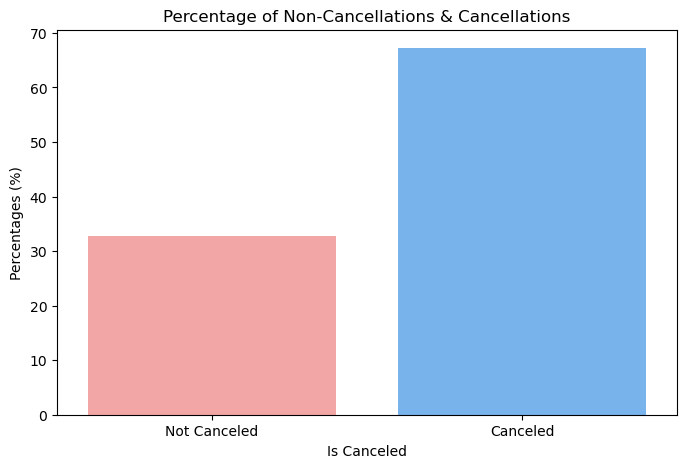

In [10]:
status_percentage = df_encoded['booking_status'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])
plt.title('Percentage of Non-Cancellations & Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentages (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0, 80, 10))

plt.show()

**Train-test split**

**XGBoost Classifier**

In [17]:
import pickle
import xgboost as xgb
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Load dataset (ensure it's the right preprocessed version)
df = df_scaled

# Standardize column names to match the web form
df.rename(columns={
    "car parking space": "car_parking_space",
    "lead time": "lead_time",
    "average price": "average_price",
    "special requests": "special_requests",
}, inplace=True)

# Convert categorical column
df["guest_type"] = df["guest_type"].apply(lambda x: 1 if x == "Family" else 0)

# Define feature columns
feature_columns = [
    "car_parking_space", "lead_time", "repeated", "average_price",
    "special_requests", "year", "month", "is_weekend",
    "total_nights", "guest_type", "market_segment_encoded",
    "room_type_Room_Type_1", "room_type_Room_Type_2", "room_type_Room_Type_3",
    "room_type_Room_Type_4", "room_type_Room_Type_5", "room_type_Room_Type_6",
    "room_type_Room_Type_7", "type_of_meal_Meal_Plan_1",
    "type_of_meal_Meal_Plan_2", "type_of_meal_Meal_Plan_3",
    "type_of_meal_Not_Selected"
]

# Ensure all features exist
for col in feature_columns:
    if col not in df.columns:
        df[col] = 0  # Add missing columns with default 0

# Define X and y
X = df[feature_columns]  # Match web form inputs
y = df["booking_status"]  # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_clf.fit(X_train, y_train)

# Save model
MODEL_PATH = "C:/Users/ASUS/Downloads/Task 3 Reem Hindi/models/xgb_trained_modelnew2.pkl"
with open(MODEL_PATH, "wb") as f:
    pickle.dump(xgb_clf, f)

print(f"Model retrained and saved successfully at {MODEL_PATH}!")


Model retrained and saved successfully at C:/Users/ASUS/Downloads/Task 3 Reem Hindi/models/xgb_trained_modelnew2.pkl!
